# 5.11 残差网络（ResNet）

思考一个问题：对神经网络模型添加新的层，充分训练后的模型是否只可能更有效地降低训练误差？理论上，原模型解的空间只是新模型解的空间的子空间。也就是说，如果我们能将新添加的层训练成恒等映射$f(x)=x$，新模型和原模型将同样有效。由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。然而在实践中，添加过多的层后训练误差往往不降反升。即使利用批量归一化带来的数值稳定性使训练深层模型更加容易，该问题仍然存在。针对这一问题，何恺明等人提出了残差网络（ResNet） [1]。它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。

* 残差块通过跨层的数据通道从而能够训练出有效的深度神经网络。

## 5.11.2 残差块

如图5.9所示，设输入为$x$。假设我们希望学出的理想映射为$f(x)$，从而作为图5.9上方激活函数的输入。左图虚线框中的部分需要直接拟合出该映射$f(x)$，而右图虚线框中的部分则需要拟合出有关恒等映射的残差映射$f(x)−x$。残差映射在实际中往往更容易优化。以本节开头提到的恒等映射作为我们希望学出的理想映射$f(x)$。我们只需将图5.9中右图虚线框内上方的加权运算（如仿射）的权重和偏差参数学成0，那么$f(x)$即为恒等映射。实际中，当理想映射$f(x)$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。图5.9右图也是ResNet的基础块，即残差块（residual block）。在残差块中，输入可通过跨层的数据线路更快地向前传播。

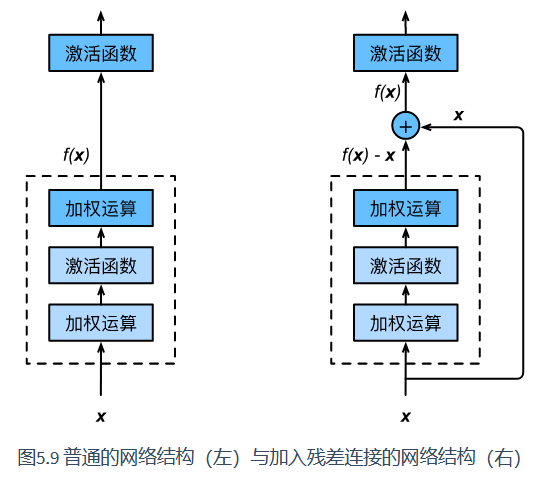

也就是说我们学到的是残差函数，在最后与输入进行相加运算得到期望学到的目标函数。

ResNet沿用了VGG全3×3卷积层的设计。残差块里首先有2个有相同输出通道数的3×3卷积层。每个卷积层后接一个批量归一化层和ReLU激活函数。然后我们将输入跳过这两个卷积运算后直接加在最后的ReLU激活函数前。这样的设计要求两个卷积层的输出与输入形状一样，从而可以相加。如果想改变通道数，就需要引入一个额外的1×1卷积层来将输入变换成需要的形状后再做相加运算。

$1\times 1$卷积可以用来升维或者降维

残差块的实现如下。它可以设定输出通道数、是否使用额外的1×1卷积层来修改通道数以及卷积层的步幅。

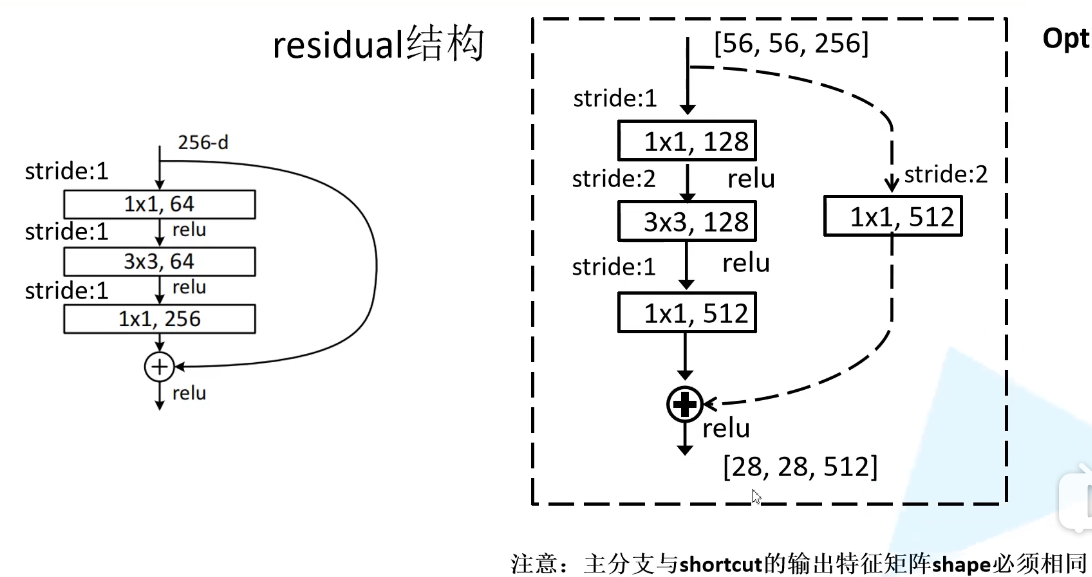

In [1]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')

class Residual(nn.Module): #残差模块
    def __init__(self,in_channels,out_channels,use_1v1conv=False,stride=1):
        super(Residual,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_1v1conv:#跳跃连接
            self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else:
            self.conv3=None
        self.bn1=nn.BatchNorm2d(out_channels)#归一化
        self.bn2=nn.BatchNorm2d(out_channels)
    
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        return F.relu(Y+X)

In [6]:
blk=Residual(3,3)
X=torch.rand((4,3,6,6))
# print(X)
print(blk(X).shape)

torch.Size([4, 3, 6, 6])


In [3]:
blk=Residual(3,6,use_1v1conv=True,stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## 5.11.2 ResNet模型

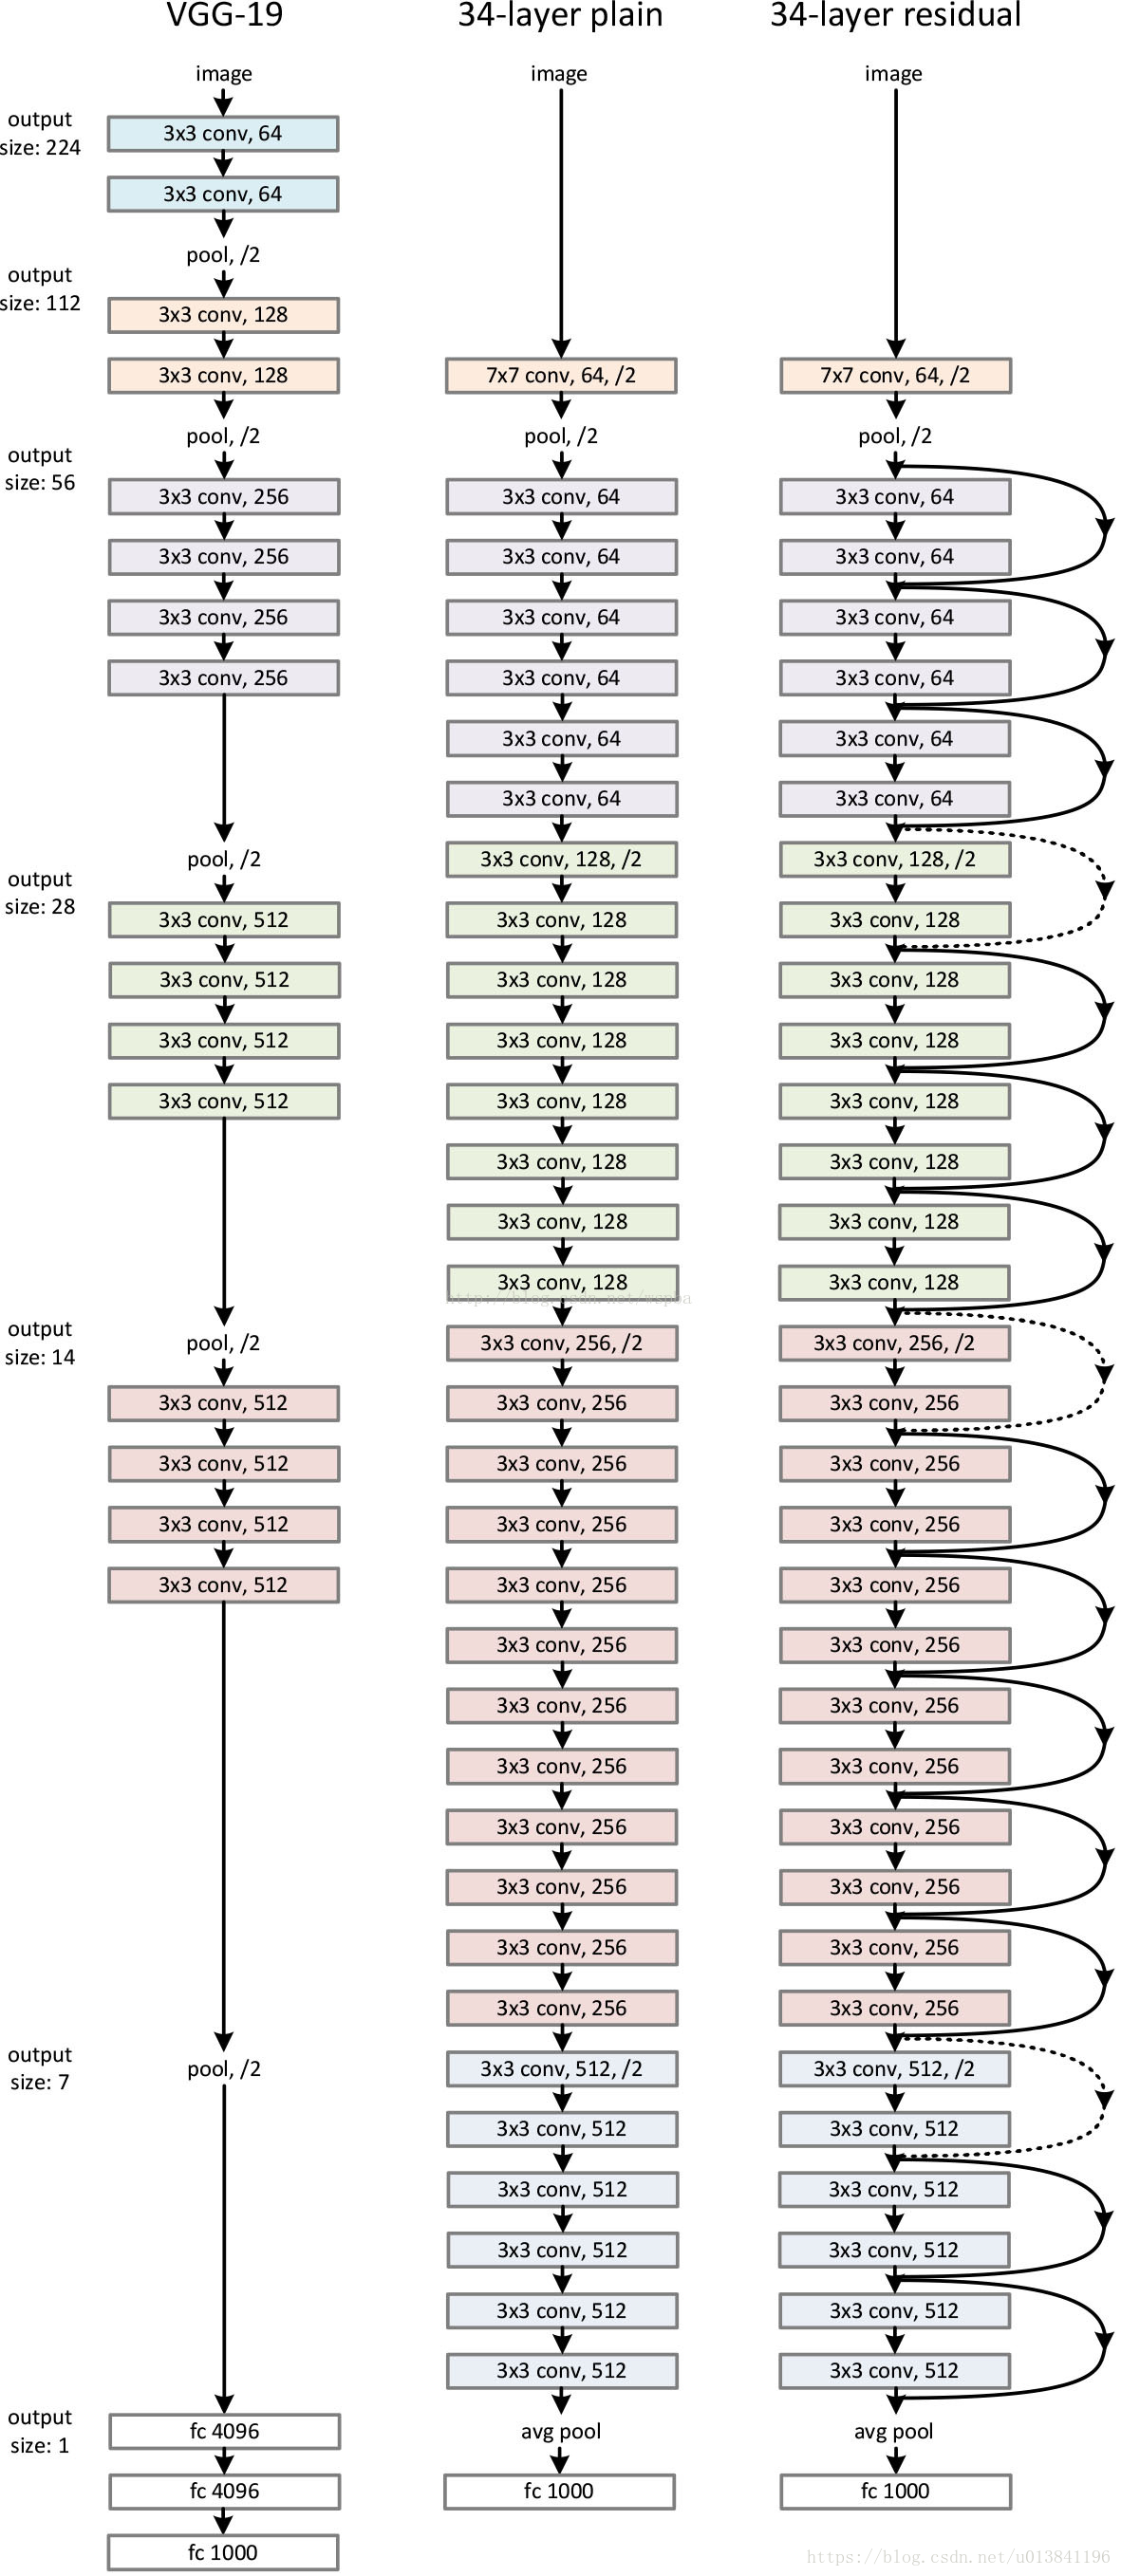

图中的卷积核的参数：3×3×64，分别指的是卷积核的大小与卷积核的个数。卷积核的深度与输入矩阵的深度对应。

ResNet的前两层跟之前介绍的GoogLeNet中的一样：在输出通道数为64、步幅为2的7×7卷积层后接步幅为2的3×3的最大池化层。不同之处在于ResNet每个卷积层后增加的批量归一化层。

In [8]:
net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

GoogLeNet在后面接了4个由Inception块组成的模块。ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大池化层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [9]:
#对第一个模块做了特别处理

def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels==out_channels #第一个模块的通道数同输入通道数一致
    blk=[]
    for i in range(num_residuals):#残差模块的数量
        if i==0 and not first_block:
            blk.append(Residual(in_channels,out_channels,use_1v1conv=True,stride=2))
        else:
            blk.append(Residual(out_channels,out_channels))
    return nn.Sequential(*blk)

In [12]:
#为ResNet加入所有残差块，每个模块使用两个残差块

net.add_module("resnet_block1",resnet_block(64,64,2,first_block=True))
net.add_module("resnet_block2",resnet_block(64,128,2))
net.add_module("resnet_block3",resnet_block(128,256,2))
net.add_module("resnet_block4",resnet_block(256,512,2))

In [ ]:
#加入全局平均池化层后接上全连接层输出

net.add_module("global_avg_pool",d2l.GlobalAvgPool2d())
net.add_module("fc",nn.Sequential(d2l.FlattenLayer(),nn.Linear(512,10)))


每个模块里有4个卷积层（不计算1×1卷积层），加上最开始的卷积层和最后的全连接层，共计18层。这个模型通常也被称为ResNet-18。通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。虽然ResNet的主体架构跟GoogLeNet的类似，但ResNet结构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

In [14]:
#观察输入形状在ResNet不同模块之间的变化

X=torch.rand((1,1,224,224))
for name,layer in net.named_children():
    X=layer(X)
    print(name,'output shape:\t',X.shape)

0 output shape:	 torch.Size([1, 64, 112, 112])
1 output shape:	 torch.Size([1, 64, 112, 112])
2 output shape:	 torch.Size([1, 64, 112, 112])
3 output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1 output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2 output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3 output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4 output shape:	 torch.Size([1, 512, 7, 7])


## 5.11.3 获取数据和训练模型

In [ ]:
#在Fashion-MNIST数据集上训练ResNet

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=96)

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

参考文献

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). Identity mappings in deep residual networks. In European Conference on Computer Vision (pp. 630-645). Springer, Cham.